In [3]:
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from random import randint, random
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from tensorflow import keras
from tqdm import tqdm

## Считаем препроцессные данные из прошлого ноутбучка

In [4]:
interactions_df = pd.read_pickle('data/interactions_preprocessed.pickle')
users_df = pd.read_pickle('data/users_preprocessed.pickle')
items_df = pd.read_pickle('data/items_preprocessed.pickle')

In [5]:
users_df.head()

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0
2,3,65_inf,0.0
3,4,18_24,0.0
4,5,35_44,0.0


In [6]:
items_df = items_df.rename(columns = {'id' : 'item_id'})

In [7]:
items_df.head()

,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [8]:
interactions_df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


## Готовим фичи пользователей

In [9]:
user_cat_feats = ["age", "sex"]

users_ohe_df = users_df.user_id
for feat in user_cat_feats:
  # получаем датафрейм с one-hot encoding для каждой категориальной фичи
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
  # конкатенируем ohe-hot датафрейм с датафреймом, 
  # который мы получили на предыдущем шаге
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()


,user_id,age_18_24,age_25_34,age_35_44,age_45_54,age_55_64,age_65_inf,sex_0.0,sex_1.0
0,1,0,0,0,1,0,0,0,0
1,2,1,0,0,0,0,0,1,0
2,3,0,0,0,0,0,1,1,0
3,4,1,0,0,0,0,0,1,0
4,5,0,0,1,0,0,0,1,0


## Готовим фичи айтемов

In [10]:
item_cat_feats = ['year']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

items_ohe_df.head()

,item_id,year_04.01.2014,year_04.08.2010,year_1000,year_1048–1123,year_1260–1327,year_1307–1321,year_1350,year_1353,year_1486,...,year_до 1937 г.,year_до 1940 г.,year_до 1942 г.,"year_до 1959 г., 2018 г.",year_до 1968 г.,year_до 1972 г.,year_ок. 355 г. до н. э.,year_около 1900 г.,year_около 500 г. до н.э.,year_первая половина XIX dtrf
0,128115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,210979,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,95632,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,247906,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,294280,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Сделаем матрицу взаимодействий

In [11]:
interactions_df.item_id.value_counts()

99357     6575
316995    2706
109201    2585
241026    2300
28889     2287
          ... 
180212       4
93290        3
132600       3
171910       3
285283       2
Name: item_id, Length: 59599, dtype: int64

In [12]:
interactions_df.user_id.value_counts()

41297     2091
150282    1352
155199     850
143558     832
86301      822
          ... 
61054        1
62524        1
131211       1
101207       1
62409        1
Name: user_id, Length: 151600, dtype: int64

<AxesSubplot:>

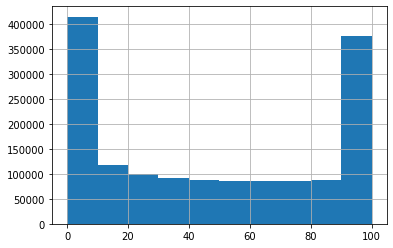

In [13]:
interactions_df.progress.hist()

In [14]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события взаимодействий, в которых пользователь прочитал
# книгу менее чем на 5 процентов
interactions_df = interactions_df[interactions_df.progress > 5]

# соберем всех пользователей, которые прочитали 
# больше 5 книг 
valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 5:
        valid_users.append(user_id)

# и соберем все книги, которые прочитали больше 10 пользователей
valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

# отбросим непопулярные книги и неактивных юзеров
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 151600
N items before: 59599

N users after: 81243
N items after: 49405


После фильтрации может получиться так, что некоторые айтемы/юзеры есть в датасете взаимодействий, но при этом они отсутствуют в датасетах айтемов/юзеров или наоборот. Поэтому найдем id айтемов и id юзеров, которые есть во всех датасетах и оставим только их.

In [15]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]
users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]

73069
49405


Соберем взаимодействия в матрицу user*item так, чтобы в строках этой матрицы были user_id, в столбцах - item_id, а на пересечениях строк и столбцов - единица, если пользователь взаимодействовал с айтемом и ноль, если нет.

Такую матрицу удобно собирать в numpy array, однако нужно помнить, что numpy array индексируется порядковыми индексами, а нам же удобнее использовать item_id и user_id.

Создадим некие внутренние индексы для user_id и item_id - uid и iid. Для этого просто соберем все user_id и item_id и пронумеруем их по порядку.

In [16]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,progress,rating,start_date,uid,iid
0,126706,14433,80,NaN,2018-01-01,57964,2181
3,46791,83486,23,5.0,2018-01-01,21551,12799
4,79313,188770,88,5.0,2018-01-01,36542,29033
5,63454,78434,87,NaN,2018-01-01,29280,12007
6,127451,14876,69,NaN,2018-01-01,58304,2251


Отнормируем матрицу взаимодействий

In [17]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), 
                             interactions_df.iid.nunique())) 

for user_id, item_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[user_id, item_id] += 1


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]

In [18]:
print(interactions_df.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_ohe_df.user_id.nunique())

set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique())

49405
49405
73069
73069


set()

Для того, чтобы можно было удобно превратить iid/uid в item_id/user_id и наоборот соберем словари 

{iid: item_id}, {uid: user_id} и {item_id: iid}, {user_id: uid}.

In [19]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

И проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним айди:

In [20]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")

In [21]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    # будем ожидать, что на вход функции прилетит три сконкатенированных 
    # вектора - вектор юзера и два вектора айтема
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    # считаем расстояния от вектора юзера до вектора хорошего айтема
    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    # и до плохого
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # считаем лосс
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0) # возвращаем ноль, если лосс отрицательный
 
    return loss

Попробуйте другие лоссы, например, BPR Triplet loss

## Генератор и семплирование

Сделаем простой генератор. Он будет брать рандромного юзера, и два разных айтема - хороший пример и плохой:
- хорошим примером будет тот айтем, который был взят из датасета взаимодействий в соответствии с распределением просмотренных айтемов для этого юзера;
- а плохим айтемом будет просто любой другой _случайный айтем_*


\* _подумайте, как можно использовать информацию о качестве взаимодействия юзеров с айтемами для более репрезентативного сэмплирования?_

In [22]:
def generator(items, users, interactions, batch_size=1024):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            # берем рандомный uid
            uid_i = randint(0, interactions.shape[0]-1)
            # id хорошего айтема
            pos_i = np.random.choice(range(interactions.shape[1]), p=interactions[uid_i])
            # id плохого айтема
            neg_i = np.random.choice(range(interactions.shape[1]))
            # фичи юзера
            uid_meta.append(users.iloc[uid_i])
            # вектор айтемов, с которыми юзер взаимодействовал
            uid_interaction.append(interactions_vec[uid_i])
            # фичи хорошего айтема
            pos.append(items.iloc[pos_i])
            # фичи плохого айтема
            neg.append(items.iloc[neg_i])
            
        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]


In [23]:
# инициализируем генератор
gen = generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                users=users_ohe_df.drop(["user_id"], axis=1), 
                interactions=interactions_vec)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (1024, 8)
вектор взаимодействий юзера с айтемами: (1024, 49405)
вектор 'хорошего' айтема: (1024, 1053)
вектор 'плохого' айтема: (1024, 1053)

вектор фичей юзера: (1024, 8)
вектор взаимодействий юзера с айтемами: (1024, 49405)


### Сделайте генаратор, который будет использовать информацию о качестве взаимодействия юзеров с айтемами для более репрезентативного сэмплирования

In [24]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (1053,)
USER_META_MODEL_SHAPE: (8,)
USER_INTERACTION_MODEL_SHAPE: (49405,)


In [25]:
def item_model(n_factors=N_FACTORS):
    # входной слой
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    
    # полносвязный слой
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    # делаем residual connection - складываем два слоя, 
    # чтобы градиенты не затухали во время обучения
    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    
    add = keras.layers.Add()([layer_1, layer_2])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    
    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    # входной слой для вектора фичей юзера (из users_ohe_df)
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    # входной слой для вектора прочтений (из iteractions_vec)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    # полносвязный слой
    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    # делаем residual connection - складываем два слоя,
    # чтобы градиенты не затухали во время обучения
    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    

    add = keras.layers.Add()([layer_1_meta, layer_2_meta])
    
    # конкатенируем вектор фичей с вектором прочтений
    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    
    return keras.models.Model([inp_meta, inp_interaction], out)

# инициализируем модели юзера и айтема
i2v = item_model()
u2v = user_model()

# вход для вектора фичей юзера (из users_ohe_df)
ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
# вход для вектора прочтений юзера (из interactions_vec)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

# вход для вектора "хорошего" айтема
pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
# вход для вектора "плохого" айтема
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

# получаем вектор юзера
ancor = u2v([ancor_meta_in, ancor_interaction_in])
# получаем вектор "хорошего" айтема
pos = i2v(pos_in)
# получаем вектор "плохого" айтема
neg = i2v(neg_in)

# конкатенируем полученные векторы
res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

# собираем модель
model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

2022-03-25 19:48:14.690779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 19:48:14.690839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-25 19:48:14.690995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-25 19:48:14.694038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-03-25 19:48:14.694082: W tensorflow/stream_executor/platform/default/dso_loader

### Попробуйте передать текстовые признаки в модель

In [26]:
model_name = 'recsys_resnet_linear'

# логируем процесс обучения в тензорборд
t_board = keras.callbacks.TensorBoard(log_dir=f'runs/{model_name}')

# уменьшаем learning_rate, если лосс долго не уменьшается (в течение двух эпох)
decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)

# сохраняем модель после каждой эпохи, если лосс уменьшился
check = keras.callbacks.ModelCheckpoint(filepath=model_name + '/epoch{epoch}-{loss:.2f}.h5', monitor="loss")


In [27]:
# компилируем модель, используем оптимайзер Adam и triplet loss
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt)

In [28]:
# модель айтема
item_model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1053)]       0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          134784      ['input_8[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 128)          16384       ['dense_7[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 128)          0           ['dense_7[0][0]',                
                                                                  'dense_8[0][0]']          

In [29]:
# модель юзера
user_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          1024        ['input_9[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 128)          16384       ['dense_10[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 49405)]      0           []                               
                                                                                            

In [30]:
# общая модель
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 49405)]      0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1053)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1053)]       0           []                               
                                                                                            

In [31]:
# начинаем обучение, не забывая дропнуть столбцы item_id и user_id 
# из датафреймов при инициализации генератора.

# batch_size можно (и лучше) поставить побольше, если вы не органичены в ресурсах

model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                    users=users_ohe_df.drop(["user_id"], axis=1), 
                    interactions=interactions_vec,
                    batch_size=64), 
          steps_per_epoch=10, 
          epochs=10, 
          initial_epoch=0,
          callbacks=[decay, t_board, check]
)

Epoch 1/10
10/10 [==============================] - 9s 819ms/step - loss: 0.4309 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 8s 827ms/step - loss: 0.4422 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 7s 821ms/step - loss: 0.4282 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 8s 827ms/step - loss: 0.4010 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 7s 783ms/step - loss: 0.4046 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.4232
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
10/10 [==============================] - 7s 780ms/step - loss: 0.4232 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 7s 787ms/step - loss: 0.4181 - lr: 8.0000e-04
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.4035
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
10/10 [==============================] -

In [32]:
# берем рандомного юзера
rand_uid = np.random.choice(list(users_ohe_df.index))

# получаем фичи юзера и вектор его прочтений айтемов
user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[rand_uid]
user_interaction_vec = interactions_vec[rand_uid]

# берем рандомный айтем
rand_iid = np.random.choice(list(items_ohe_df.index))
# получаем фичи айтема
item_feats = items_ohe_df.drop(["item_id"], axis=1).iloc[rand_iid]

# получаем вектор юзера
user_vec = u2v.predict([np.array(user_meta_feats).reshape(1, -1), 
                        np.array(user_interaction_vec).reshape(1, -1)])

# и вектор айтема
item_vec = i2v.predict(np.array(item_feats).reshape(1, -1))

# считаем расстояние между вектором юзера и вектором айтема
from sklearn.metrics.pairwise import euclidean_distances as ED

ED(user_vec, item_vec)

array([[1.3175488]], dtype=float32)

In [33]:
user_vec

array([[-1.47005320e-02, -1.93223506e-01, -1.47019699e-01,
         4.21393476e-02,  2.48807490e-01,  1.29894624e-02,
        -1.53392432e-02,  4.42417264e-02,  2.25073118e-02,
         1.81198016e-01, -3.24286781e-02,  9.18467790e-02,
         8.35282505e-02,  7.53866434e-02, -2.24320125e-02,
        -3.53401266e-02,  2.30907314e-02,  9.36663300e-02,
        -4.42252867e-02, -1.87661961e-01, -4.74157743e-02,
         1.10008866e-02, -2.08519623e-02,  3.09535824e-02,
        -1.93237528e-01, -1.45721287e-01,  4.85737137e-02,
        -4.52427380e-02,  1.35906273e-02,  9.94011983e-02,
         7.96716064e-02, -9.35771540e-02, -1.37814045e-01,
        -1.03831284e-01,  1.17299236e-01,  4.33496991e-03,
         3.36484499e-02, -5.77991307e-02,  9.75737870e-02,
         2.73947343e-02, -1.22138873e-01,  4.77692299e-02,
        -6.14956021e-02,  3.48672867e-02,  9.91697684e-02,
        -2.23741218e-01,  6.73848912e-02, -3.31121124e-02,
        -1.96660347e-02, -2.52641924e-02, -7.22821578e-0

In [34]:
item_vec

array([[ 0.00131433, -0.03466852, -0.07290763,  0.05060743,  0.02380628,
        -0.03762262, -0.02138716, -0.03987746, -0.04066788, -0.08234528,
         0.02235205,  0.04046446,  0.04477913,  0.02629855,  0.06323895,
        -0.02777346,  0.00042664,  0.0202487 , -0.03179989, -0.09246481,
         0.09919274, -0.02959276,  0.05547597, -0.04081825,  0.06075792,
         0.03754909, -0.05437966,  0.00704147,  0.08419368,  0.0494138 ,
        -0.05806733, -0.00776458, -0.08601099,  0.05509662, -0.02440422,
        -0.0752933 , -0.03586897, -0.00301363, -0.04516621,  0.04792394,
        -0.05786549,  0.03010905,  0.03373662, -0.04762375,  0.02746732,
         0.12177229, -0.05340029,  0.03588503, -0.0372989 ,  0.00512118,
         0.00943576, -0.05171439,  0.04285187,  0.02933875, -0.0083212 ,
         0.00182216,  0.00187037, -0.0116553 ,  0.06024579, -0.01713607,
        -0.02548593,  0.01210699, -0.04749813, -0.01235499, -0.02456915,
        -0.04844279, -0.0268911 ,  0.05531415, -0.0

In [35]:
# получаем фичи всех айтемов
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
# получаем векторы всех айтемов
items_vecs = i2v.predict(items_feats)

# считаем расстояния
dists = ED(user_vec, items_vecs)

In [36]:
top5_iids = np.argsort(dists, axis=1)[0][:5]
top5_iids

array([ 9207,  3849, 18737, 13370,  5026])

In [37]:
top5_item_ids = [iid_to_item_id[iid] for iid in top5_iids]
top5_item_ids

[59943, 25614, 121419, 87178, 33170]

In [38]:
recommended_titles = items_df.loc[items_df.item_id.isin(top5_item_ids)].title
recommended_titles

42086                             Моя прекрасная принцесса
45785                            Интерес-Кроссворд 48-2014
48854                                      Лекции о Солнце
51418    Страдания от бессмысленности жизни. Das Leiden...
57475                                Красота как наказание
Name: title, dtype: object

In [39]:
iids_viewed = np.where(interactions_vec[rand_uid] > 0)
viewed_titles = items_df.iloc[iids_viewed].title
viewed_titles

3678     Ремонт и изменение дизайна квартиры
16125                  Звездный час адвоката
16797                    Скажи миру – «нет!»
23315                     Бог-Император Дюны
26938                   Свидание под мантией
27343                                Партнер
Name: title, dtype: object